# Проект :<br>  
### Требуется выполнить следующие действия с данными по облигациям на дату формирования данных:  
  
       

<div style="text-align: justify"><br><br> 1. Оценить рынок рублевых облигаций по распределению купонной доходности, предложить разделение на кластеры по купонной доходности.Предложить графическое представление полученных групп/кластеров. (график)</div>

<div style="text-align: justify"> 2. По низкорисковым рублевым облигациям с датой промежуточной выплаты по  купонам не более 20% купонного периода назад до текущей даты и облигациям выпущенным в аналогичный период, рассчитать доходность последующих купонов по отобранным облигациям с учетом разницы номинала и цены продажи, а также с учетом налоговых отчислений на период год с текущей дата. (график и/или таблица)</div>


### Могут быть использованы следующие поля (а также все остальные) в любых комбинациях:<br> 
<div style="text-align: justify"><br> 'SECID' - Код ценной бумаги,<br>'SHORTNAME' - Краткое наименование,<br>'NAME' Полное наименование,<br>'FACEVALUE' - Номинальная стоимость,<br>'FACEUNIT' - валюта,<br>'DURATION' - дюрация,<br>'IS_QUALIFIED_INVESTORS' - признак продукта для квалифицированных инвесторов,<br>'HIGH_RISK' - признак уровня риска,<br> 'COUPONFREQUENCY' – число купонов в год,<br>'COUPONDATE' - Дата выплаты купона,<br>'COUPONPERCENT' - Ставка купона, %,<br>
 'COUPONVALUE' - Сумма купона, в валюте номинала,<br>'OFFERDATE' - Дата оферты,<br>'EMITENTNAME' – наименование эмитента,<br>
'INN' – ИНН эмитента,<br>'PRICE' – текущий % от FACEVALUE,<br>'PRICE_RUB' - котировка</div>

### Пояснения:<br> 
<div style="text-align: justify">
1. Для получения текущей даты можно использовать метод datetime.date.today();<br>                                                2. Период расчета доходности рекомендуется выбирать 365 дней с текущей даты; <br>                                                3. Нужно учитывать накопленный купонный доход (НКД) и разницу котировки и номинала ; <br>                                        4. В общем случае процентный доход при ставке НДФЛ 13% будет  Profit =(Цена_Номинальная – Цена_покупки – НКД +<br>   0.87*Купонный_доход_руб*X_лет)* 100%  /(Цена_покупки + НКД) (комиссией брокера пренебрегаем) <br>                                5. Период расчета НКД: df['COUPONDAYSPASSED']/df['COUPONLENGTH'] , рекомендуется  выбирать меньше или равный 0.2.<br>
Если удовлетворяет условию, полученная величина умножается на COUPONPERCENT/COUPONFREQUENCY. <br>                 
6. Датасет содержит данные, которые нужно преобразовывать в форматы python, а также пустые и искаженные данные, с которыми нужно что-то решить.</div>

In [209]:
import pandas as pd
import requests
from datetime import datetime, date, timedelta
import io
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
from bs4 import BeautifulSoup
import re

In [210]:
bond_url = f'https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&limit=unlimited&lang=ru'

In [211]:
s = requests.get(bond_url).content

In [212]:
bond = pd.read_csv(io.StringIO(s.decode('cp1251')), sep=';', header=1)

In [213]:
bond.describe()

,LISTLEVEL,ISSUESIZE,IS_COLLATERAL,IS_EXTERNAL,EVENINGSESSION,DURATION,IS_QUALIFIED_INVESTORS,HIGH_RISK,COUPONFREQUENCY,COUPONDAYSPASSED,COUPONDAYSREMAIN,COUPONLENGTH,DAYSTOREDEMPTION,INN,LOTSIZE,LIMIT1,LIMIT2
count,2437.000000,2.677000e+03,2697.000000,2697.000000,2697.000000,1867.000000,2697.000000,2697.000000,2322.000000,2683.000000,2683.000000,2683.000000,2649.000000,2.546000e+03,2697.000000,8.780000e+02,8.780000e+02
mean,2.382848,3.224802e+08,0.140897,0.155729,0.129774,850.330477,0.185020,0.062291,3.054264,145.257548,228.075662,373.333209,1657.399773,6.081548e+09,1.447164,3.350430e+05,1.674611e+06
std,0.848016,4.166856e+09,0.347980,0.362665,0.336117,685.582076,0.388386,0.241729,2.303844,234.092429,468.882621,614.149759,1934.698803,2.939775e+09,19.423676,8.351049e+05,4.175706e+06
min,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-7.000000,1.000000,21.000000,0.000000,4.550000e+02,1.000000,1.700000e+01,8.500000e+01
25%,2.000000,3.243090e+05,0.000000,0.000000,0.000000,364.500000,0.000000,0.000000,2.000000,30.000000,39.000000,91.000000,596.000000,5.405966e+09,1.000000,1.000000e+05,5.000000e+05
50%,3.000000,2.450000e+06,0.000000,0.000000,0.000000,728.000000,0.000000,0.000000,2.000000,74.000000,74.000000,182.000000,1133.000000,7.707084e+09,1.000000,2.000000e+05,1.000000e+06
75%,3.000000,1.000000e+07,0.000000,0.000000,0.000000,1132.000000,0.000000,0.000000,4.000000,143.000000,155.000000,183.000000,1875.000000,7.719272e+09,1.000000,3.000000e+05,1.500000e+06
max,3.000000,9.649987e+10,1.000000,1.000000,1.000000,5639.000000,1.000000,1.000000,12.000000,4551.000000,5339.000000,7304.000000,32577.000000,9.909570e+09,1000.000000,1.200000e+07,6.000000e+07


In [214]:
bond.dtypes

SECID                      object
SHORTNAME                  object
NAME                       object
TYPENAME                   object
ISIN                       object
REGNUMBER                  object
LISTLEVEL                 float64
FACEVALUE                  object
FACEUNIT                   object
ISSUESIZE                 float64
IS_COLLATERAL               int64
IS_EXTERNAL                 int64
PRIMARY_BOARDID            object
PRIMARY_BOARD_TITLE        object
MATDATE                    object
IS_RII                     object
ISSUEDATE                  object
EVENINGSESSION              int64
DURATION                  float64
IS_QUALIFIED_INVESTORS      int64
HIGH_RISK                   int64
COUPONFREQUENCY           float64
YIELDATWAP                 object
COUPONDATE                 object
COUPONPERCENT              object
COUPONVALUE                object
COUPONDAYSPASSED          float64
COUPONDAYSREMAIN          float64
COUPONLENGTH              float64
ISSUEDATE.1   

In [215]:
bond.shape

(2697, 53)

#### Оставляем только рублевые облигации


In [216]:

bond_rub = bond.drop(bond[bond['FACEUNIT']!='RUB'].index  )                             

#### Определяем поля, содержащие Nan

In [217]:

bond_rub.isna().sum()

SECID                        0
SHORTNAME                    0
NAME                         0
TYPENAME                     0
ISIN                         0
REGNUMBER                   80
LISTLEVEL                  156
FACEVALUE                    0
FACEUNIT                     0
ISSUESIZE                   19
IS_COLLATERAL                0
IS_EXTERNAL                  0
PRIMARY_BOARDID              0
PRIMARY_BOARD_TITLE          0
MATDATE                     28
IS_RII                    2302
ISSUEDATE                  141
EVENINGSESSION               0
DURATION                   645
IS_QUALIFIED_INVESTORS       0
HIGH_RISK                    0
COUPONFREQUENCY            355
YIELDATWAP                1161
COUPONDATE                   8
COUPONPERCENT               57
COUPONVALUE                 61
COUPONDAYSPASSED             8
COUPONDAYSREMAIN             8
COUPONLENGTH                 8
ISSUEDATE.1                141
INITIALFACEVALUE             0
SECSUBTYPE                2210
STARTDAT

#### Количество "пустых" записей очень большое.Удалять все Nan из датафрейма не будем, чтобы не снижать объем выборки. В случае очистки bond_rub.dropna() в датасете останется ~ 20% записей от первоначального значения.
#### Удалять Nan будем только из полей, которые используются в расчетах.

#### Определяем количество записей в полях, необходимых для расчетов показателя Доходность, содержащих Nan

In [218]:
bond_rub[['COUPONPERCENT','COUPONFREQUENCY','COUPONLENGTH','COUPONDAYSPASSED', 'COUPONLENGTH']].isna().sum()

COUPONPERCENT        57
COUPONFREQUENCY     355
COUPONLENGTH          8
COUPONDAYSPASSED      8
COUPONLENGTH          8
dtype: int64

#### Выводим список наименований организаций, по которым в расчетных полях содержатся Nan. От данных записей будем очищать датафрейм, т.к. нет возможности достоверно заменить Nan на реальные значения

In [219]:
bond_rub['NAME'][pd.isnull(bond_rub['PRICE']) | pd.isnull(bond_rub['COUPONVALUE']) | pd.isnull(bond_rub['COUPONLENGTH']) | pd.isnull(bond_rub['COUPONPERCENT']) | pd.isnull(bond_rub['COUPONFREQUENCY'])]

14        "НПФ" ООО об.сер. 01
23      Волга-Спорт АО обл. 01
25         Uranium One Inc. 01
138        Финстоун ООО об. 01
152     Арчер Финанс ООО об.01
                 ...          
2664     BCS SP Plc Series 170
2674     BCS SP Plc Series 189
2677     BCS SP Plc Series 194
2688     BCS SP Plc Series 208
2694     BCS SP Plc Series 215
Name: NAME, Length: 541, dtype: object

#### Оставляем строки, не содержащие Nan в полях, которые будут использоваться в расчетах Доходности далее. 

In [220]:
bond_rub = bond_rub.dropna(subset = ['COUPONLENGTH', 'COUPONPERCENT', 'COUPONFREQUENCY','PRICE', 'COUPONVALUE'])
bond_rub = bond_rub.reset_index(drop=True)

#### Количество записей в датафрейме, которые будем использовать для анализа

In [221]:
bond_rub.shape

(1779, 53)

#### Проводим расчет накопленного купонного дохода NKD

In [222]:
bond_rub['NKD'] = bond_rub['COUPONDAYSPASSED']/bond_rub['COUPONLENGTH']

In [223]:
bond_rub[['NKD','COUPONDAYSPASSED','COUPONLENGTH']].head()

,NKD,COUPONDAYSPASSED,COUPONLENGTH
0,0.726776,133.0,183.0
1,0.560440,102.0,182.0
2,0.869565,160.0,184.0
3,0.204420,37.0,181.0
4,0.505495,92.0,182.0


#### Очистка полей, необходимых для расчетов показателя Доходности от "мусорных" символов, оставляем только цифры и точку

In [224]:
list = ['PRICE_RUB','PRICE','FACEVALUE','COUPONPERCENT','COUPONVALUE']
for i in list:
    bond_rub[i].replace(regex=True, inplace=True, to_replace=r'[^0-9,\.\-]',value=r'')
    bond_rub[i] = bond_rub[i].str.replace(',', '.').astype(float)

#### Проводим расчет накопленного купонного дохода исходя из следующих рекомендаций
Период расчета НКД: df['COUPONDAYSPASSED']/df['COUPONLENGTH'] , рекомендуется выбирать меньше или равный 0.2.
Если удовлетворяет условию, полученная величина умножается на COUPONPERCENT/COUPONFREQUENCY.


In [225]:
bond_rub['COUPON_K']=bond_rub['COUPONPERCENT']/bond_rub['COUPONFREQUENCY']

In [226]:
bond_rub['NKD_02']=np.where(bond_rub['NKD']<= 0.2,bond_rub['NKD']*bond_rub['COUPON_K'],bond_rub['NKD'])

#### Проводим расчет Доходности исходя из следующих условий 
В общем случае процентный доход при ставке НДФЛ 13% будет:
Profit =(Цена_Номинальная – Цена_покупки – НКД + 0.87*Купонный_доход_руб*X_лет)*100% /(Цена_покупки + НКД)
(комиссией брокера пренебрегаем)

#### Расчет Купонный доход в рублях

In [227]:

bond_rub['COUPONE_GANE']=(bond_rub['COUPONPERCENT']*bond_rub['FACEVALUE'])/100

#### Расчет НКД в рублях 

In [228]:
bond_rub['NKD_RUB']=(bond_rub['NKD_02']*bond_rub['FACEVALUE'])/100

#### Расчет дополнительного показателя  Прибыль/убыток  в рублях 

In [229]:
bond_rub['PROFIT_LOSS']= bond_rub['FACEVALUE'] - bond_rub['PRICE_RUB'] - bond_rub['NKD_RUB']

In [230]:
bond_rub[['FACEVALUE','PRICE','PRICE_RUB','NKD_02','NKD_RUB','PROFIT_LOSS']].tail()

,FACEVALUE,PRICE,PRICE_RUB,NKD_02,NKD_RUB,PROFIT_LOSS
1774,100000.0,80.99,80990.00,0.622951,622.950820,18387.049180
1775,100000.0,102.59,102590.00,0.677596,677.595628,-3267.595628
1776,100000.0,102.28,102280.00,0.620879,620.879121,-2900.879121
1777,100000.0,100.00,100812.50,0.808011,808.011050,-1620.511050
1778,100000.0,99.95,101650.83,0.429348,429.347826,-2080.177826


#### Расчет купонного дохода с уплатой 13% НДФЛ в рублях

In [231]:
bond_rub['COUPONE_GANE_NDFL'] = bond_rub['COUPONE_GANE'] * 0.87

In [232]:
bond_rub[['FACEVALUE','PRICE','PRICE_RUB','NKD_02','NKD_RUB','PROFIT_LOSS','COUPONPERCENT','COUPONE_GANE','COUPONE_GANE_NDFL']].head()

,FACEVALUE,PRICE,PRICE_RUB,NKD_02,NKD_RUB,PROFIT_LOSS,COUPONPERCENT,COUPONE_GANE,COUPONE_GANE_NDFL
0,1000.0,99.34,1015.26,0.726776,7.267760,-22.527760,6.00,60.0,52.200
1,1000.0,99.76,1019.54,0.560440,5.604396,-25.144396,7.85,78.5,68.295
2,1000.0,103.93,1072.18,0.869565,8.695652,-80.875652,7.50,75.0,65.250
3,1000.0,112.07,1130.08,0.204420,2.044199,-132.124199,9.25,92.5,80.475
4,1000.0,100.18,1021.59,0.505495,5.054945,-26.644945,7.85,78.5,68.295


#### Расчет показателя Доходность в рублях

In [233]:
bond_rub['PROFIT']=(bond_rub['PROFIT_LOSS'] + (bond_rub['COUPONE_GANE_NDFL'])) * 100 / (bond_rub['PRICE_RUB'] + bond_rub['NKD_RUB'] )

In [234]:
bond_rub[['FACEVALUE','PRICE_RUB','NKD_RUB','PROFIT_LOSS','COUPONPERCENT','COUPONE_GANE_NDFL','PROFIT']].tail()

,FACEVALUE,PRICE_RUB,NKD_RUB,PROFIT_LOSS,COUPONPERCENT,COUPONE_GANE_NDFL,PROFIT
1774,100000.0,80990.00,622.950820,18387.049180,8.000,6960.00,31.057631
1775,100000.0,102590.00,677.595628,-3267.595628,9.000,7830.00,4.418041
1776,100000.0,102280.00,620.879121,-2900.879121,8.500,7395.00,4.367427
1777,100000.0,100812.50,808.011050,-1620.511050,8.125,7068.75,5.361358
1778,100000.0,101650.83,429.347826,-2080.177826,7.850,6829.50,4.652541


#### Для дальнейшего анализа оставляем только доходные ценные бумаги и определяем объем полученных данных

In [235]:
bond_rub = bond_rub[(bond_rub['PROFIT'] > 0)] 

In [236]:
bond_rub.shape

(1635, 61)

#### На основании анализа рынка доходных облигаций в 2021 (длинных и коротких) определено, что эффективная доходность к погашению в % годовых колеблется от 4.2 до 8.5 % На основании вышепреведенных данных, оставляем значения эффективной доходности в  диапазоне от 7% ( КeyRate)  до  ~ 20 (выше статистической, но убираем выбросы, связанные с влиянием котировки облигаций)  

In [237]:
bond_rub['PROFIT'].max()

8633.965163147792

#### C сайта ЦБ РФ получаем ключевую ставку

In [238]:
def kget_kl_stavka():
    kluch_url = f'https://www.cbr.ru/hd_base/KeyRate/?UniDbQuery.Posted=True&UniDbQuery.From='+"{}".format((datetime.today().strftime("%d.%m.%Y")))+'&UniDbQuery.To='+"{}".format((datetime.today().strftime("%d.%m.%Y")))
    s_kluch=requests.get(kluch_url).content
    soup = BeautifulSoup(str(s_kluch), 'lxml')
    soup.find_all(soup.td)
    qwe = soup.select('td:nth-child(2)')
    regex = re.compile('[^0-9,\.\-]')
    return(regex.sub('', str(qwe)))

KeyRate=float(kget_kl_stavka().replace(',', '.'))
print(KeyRate)

6.75


In [239]:
bond_rub = bond_rub[(bond_rub['PROFIT'] <= 20) & (bond_rub['COUPONPERCENT'] >= KeyRate)]

In [240]:
bond_rub['PROFIT'].max()

19.614050660548557

#### Анализируем количество записей, оставшееся в датафрейме

In [241]:
bond_rub.shape

(1098, 61)

#### Определяем количество кластеров. Для анализа отобраны столбцы, влияющие на доходность
#### При кластеризации методом k-средних количество кластеров чаще всего оценивают с помощью «метода локтя»

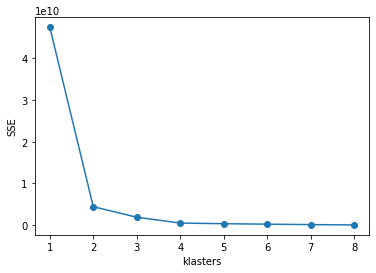

Вывод - делим на 3 кластера


In [242]:
SSE = []
for k in range(1,9):
    estimator = KMeans (n_clusters = k) 
    estimator.fit(bond_rub[['PROFIT','NKD_RUB']])
    SSE.append(estimator.inertia_)
    X = range(1,9)

plt.xlabel('klasters')
plt.ylabel('SSE')
plt.plot(X,SSE,'o-')
plt.show()
print('Вывод - делим на 3 кластера')


#### Выполняем кластеризацию по К-средних

In [243]:
kmeans = KMeans(n_clusters=3)
pred=kmeans.fit_predict(bond_rub[['PROFIT','NKD_RUB']])
bond_rub['ClusterID'] = pred
bond_rub.ClusterID.value_counts(normalize=False)

0    1083
1      10
2       5
Name: ClusterID, dtype: int64

#### Среднее значение доходности для каждого из кластеров

In [244]:
print((bond_rub['PROFIT'].iloc[np.where(bond_rub.ClusterID==0)]).mean())
print((bond_rub['PROFIT'].iloc[np.where(bond_rub.ClusterID==1)]).mean())
print((bond_rub['PROFIT'].iloc[np.where(bond_rub.ClusterID==2)]).mean())


5.8827507717410965
5.177732722883182
7.664880577564228


#### Строим диаграмму распределения кластеров по средним значениям доходности

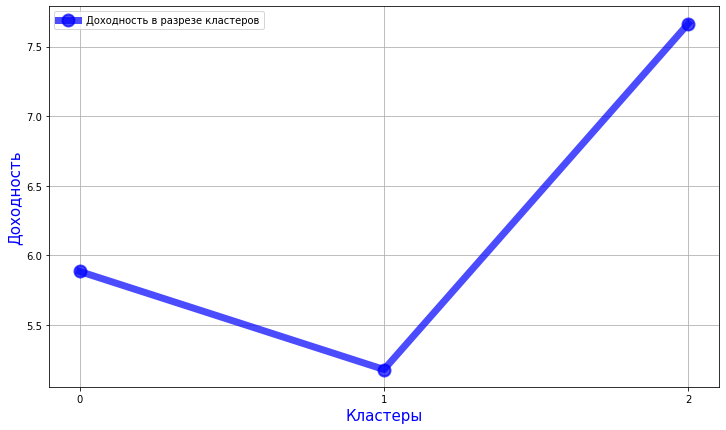

In [245]:
y = bond_rub[['PROFIT', 'ClusterID']].groupby('ClusterID').mean()
plt.figure(figsize=(12, 7))
plt.xlabel('Кластеры', fontsize=15, color='blue')
plt.ylabel('Доходность', fontsize=15, color='blue')
plt.xticks([0,1,2])
plt.plot( y, 'o-b', alpha=0.7, label="Доходность в разрезе кластеров", lw=7, mec='b', mew=2, ms=12)
# plt.plot(x, y2, 'v-.g', label="second", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

#### Распределение значений в разрезе по кластерам

In [246]:
X = bond_rub[['PROFIT','NKD_RUB',]].to_numpy()
kmeans = KMeans(n_clusters=3) 
kmeans.fit(X)
print(kmeans.cluster_centers_)

[[5.88275077e+00 3.75068025e+01]
 [5.17773272e+00 6.47126644e+04]
 [7.66488058e+00 2.90090137e+04]]


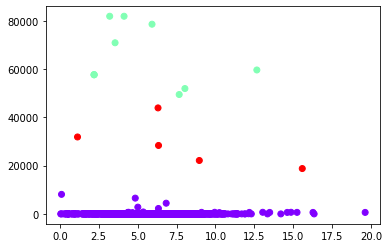

In [247]:
plt.scatter(X[:,0],X[:,1], c=kmeans.labels_, cmap='rainbow')

#### Топ 5 компаний в разрезе кластеров

In [248]:
top_cl2 = bond_rub[['PROFIT', 'NAME','ClusterID']].iloc[np.where(bond_rub.ClusterID==2)]
top_cl1 = bond_rub[['PROFIT', 'NAME','ClusterID']].iloc[np.where(bond_rub.ClusterID==1)]
top_cl0 = bond_rub[['PROFIT', 'NAME','ClusterID']].iloc[np.where(bond_rub.ClusterID==0)]

#### Топ 5 компаний по кластеру 2

In [249]:
Top_5_cluster_2 = top_cl2.sort_values(by='PROFIT',ascending=False).head()
Top_5_cluster_2.head()

,PROFIT,NAME,ClusterID
1304,15.574440,Банк ВТБ ПАО СУБ-Т2-1,2
1305,8.961127,Банк ВТБ ПАО СУБ-Т2-2,2
1669,6.341475,Газпром капитал ООО 001Б-03,2
1660,6.309325,Сбербанк 002СУБ-03R,2
804,1.138036,АЛЬФА-БАНК С01-01,2


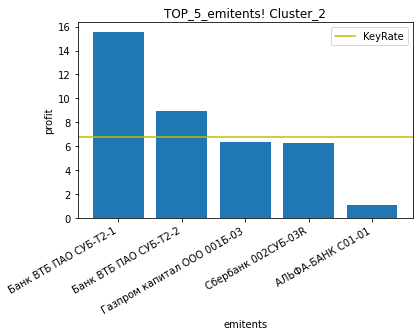

In [250]:
emitents =Top_5_cluster_2['NAME']
profit = Top_5_cluster_2['PROFIT']
fig, ax = plt.subplots()
plt.bar(emitents, profit)
plt.axhline(y=KeyRate, color = 'y')
plt.plot([KeyRate],'y',label='KeyRate')
plt.legend()
plt.title("TOP_5_emitents! Cluster_2")
plt.xlabel("emitents")
plt.ylabel("profit")
fig.autofmt_xdate()

#### Топ 5 компаний по кластеру 1

In [251]:
Top_5_cluster_1 = top_cl1.sort_values(by='PROFIT',ascending=False).head()
Top_5_cluster_1.head()

,PROFIT,NAME,ClusterID
1397,12.657152,Сбербанк 002СУБ-02R,1
1681,8.036229,Банк ВТБ ПАО СУБ-Т1-12,1
1680,7.668902,Банк ВТБ ПАО СУБ-Т1-11,1
949,5.923921,Банк ВТБ ПАО Т2-3,1
1558,4.127877,Банк ВТБ ПАО СУБ-Т1-5,1


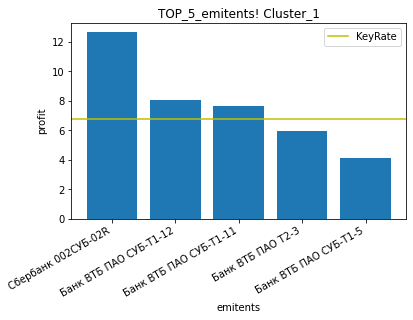

In [252]:
emitents =Top_5_cluster_1['NAME']
profit = Top_5_cluster_1['PROFIT']
fig, ax = plt.subplots()
plt.bar(emitents, profit)
plt.axhline(y=KeyRate, color = 'y')
plt.plot([KeyRate],'y',label='KeyRate')
plt.legend()
plt.title("TOP_5_emitents! Cluster_1")
plt.xlabel("emitents")
plt.ylabel("profit")
fig.autofmt_xdate()

#### Топ 5 компаний по кластеру 0

In [253]:
Top_5_cluster_0 = top_cl0.sort_values(by='PROFIT',ascending=False).head()
Top_5_cluster_0

,PROFIT,NAME,ClusterID
1765,19.614051,BCS SP Plc Series 92,0
1444,16.335696,ОР ООО 001P-04,0
1755,16.263338,BCS SP Plc Series 51,0
1754,15.237833,BCS SP Plc Series 42,0
1767,14.853121,BCS SP Plc Series 2020-16,0


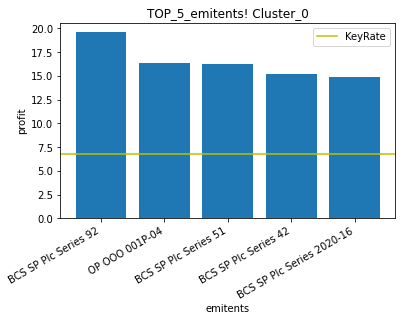

In [254]:
emitents =Top_5_cluster_0['NAME']
profit = Top_5_cluster_0['PROFIT']
fig, ax = plt.subplots()
plt.bar(emitents, profit)
plt.axhline(y=KeyRate, color = 'y')
plt.plot([KeyRate],'y',label='KeyRate')
plt.legend()
plt.title("TOP_5_emitents! Cluster_0")
plt.xlabel("emitents")
plt.ylabel("profit")
fig.autofmt_xdate()

#### Проводим расчет даты, исходя из условия по периоду 20% от текущей даты 

In [255]:
bond_rub['COUPONDAYSPASSED_0.20']= round(bond_rub['COUPONDAYSPASSED'] * 0.20)

#### Рассчитываем дату промежуточной выплаты по купонам не более 20% купонного периода назад до текущей даты

In [256]:
list_date = []
 
for index, row in bond_rub.iterrows():
    list_date.append(date.today() - timedelta(days=row['COUPONDAYSPASSED_0.20']))
bond_rub['date_NEW'] = list_date

#### Приводим  формат столбцов с датами к типу datetime

In [257]:
bond_rub['ISSUEDATE'] = pd.to_datetime(bond_rub['ISSUEDATE'])
bond_rub['date_NEW'] = pd.to_datetime(bond_rub['date_NEW'])
bond_rub['COUPONDATE'] = pd.to_datetime(bond_rub['COUPONDATE'])

In [258]:
bond_rub[['date_NEW','ISSUEDATE','COUPONDATE']].dtypes

date_NEW      datetime64[ns]
ISSUEDATE     datetime64[ns]
COUPONDATE    datetime64[ns]
dtype: object

#### Оставляем данные, удовлетворяющие условию: "COUPONDATE" и "ISSUEDATE" меньше или равны "date_NEW " и "HIGH_RISK" = 0

In [259]:
bond_rub = bond_rub[(bond_rub['COUPONDATE'] <= bond_rub['date_NEW']) & (bond_rub['COUPONDATE'] <= bond_rub['date_NEW']) & (bond_rub['HIGH_RISK'] == 0 )]

#### PROFIT посчитан. Определяем Топ 5 эмитентов по доходности и выводим на гистограмму

In [260]:
Top_5 = bond_rub.sort_values(by='PROFIT',ascending=False).head()

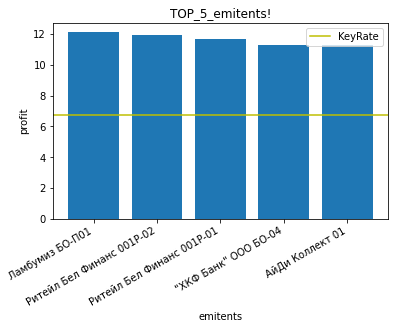

In [261]:
emitents =Top_5['NAME']
profit = Top_5['PROFIT']
fig, ax = plt.subplots()
plt.bar(emitents, profit)
plt.axhline(y=KeyRate, color = 'y')
plt.plot([KeyRate],'y',label='KeyRate')
plt.legend()
plt.title("TOP_5_emitents!")
plt.xlabel("emitents")
plt.ylabel("profit")
fig.autofmt_xdate()